##Upload dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/cansat2024/submission/Dataset/
%cp -av v1 /content/dataset

In [ ]:
ds = 0
ds += len(os.listdir('/content/dataset/test'))
ds += len(os.listdir('/content/dataset/train'))
ds += len(os.listdir('/content/dataset/valid'))
print(ds)

296


In [ ]:
%cd /content/drive/MyDrive/cansat2024/submission/Dataset/
%cp unet_model.h5 /content/unet_model.h5

/content/drive/MyDrive/cansat2024/submission/Dataset


### using model

##Install Dependencies

In [ ]:
!apt-get install tree
!pip install tensorflow scikit-image
!pip install tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (41.4 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


##Training

In [ ]:
import json
import numpy as np
from tensorflow import keras
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO

# Load COCO annotations
train_annotation_path = '/content/dataset/train_annotation.json'
valid_annotation_path = '/content/dataset/valid_annotation.json'
test_annotation_path = '/content/dataset/test_annotation.json'

with open(train_annotation_path, 'r') as f:
    train_annotations = json.load(f)

with open(valid_annotation_path, 'r') as f:
    valid_annotations = json.load(f)

with open(test_annotation_path, 'r') as f:
    test_annotations = json.load(f)

# Set up COCO API for loading images
coco_train = COCO(train_annotation_path)
coco_valid = COCO(valid_annotation_path)
coco_test = COCO(test_annotation_path)
# Image preprocessing function
# Image preprocessing function
def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return img_array

def unet_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = layers.Dropout(0.2)(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    up2 = layers.UpSampling2D(size=(2, 2))(pool1)
    up2 = layers.Conv2D(64, 2, activation='relu', padding='same')(up2)

    # Crop conv1 to match the size of up2
    crop_size = conv1.shape[1] - up2.shape[1]
    cropped_conv1 = layers.Cropping2D(cropping=crop_size // 2)(conv1)

    # Concatenate cropped_conv1 and up2
    merge2 = layers.concatenate([cropped_conv1, up2], axis=3)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge2)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)

    # # Output layer
    # outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(conv2)

    # # Encoder
    # conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    # conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    # pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # # Decoder
    # up2 = layers.UpSampling2D(size=(2, 2))(pool1)
    # up2 = layers.Conv2D(64, 2, activation='relu', padding='same')(up2)
    # merge2 = layers.concatenate([conv1, up2], axis=3)
    # conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge2)
    # conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(conv2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


# Load and preprocess data
def load_and_preprocess_data(coco, annotations, image_folder):
    images = []
    masks = []

    for annotation in annotations['annotations']:
        image_info = coco.loadImgs(annotation['image_id'])[0]
        image_path = f"/content/dataset/{image_folder}/{image_info['file_name']}"

        # Load original mask
        mask = coco.annToMask(annotation)
        # Resize mask to match model output size
        mask = tensorflow.image.resize(np.expand_dims(mask, axis=-1), (256, 256))

        images.append(preprocess_image(image_path))
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load and preprocess training data
train_images, train_masks = load_and_preprocess_data(coco_train, train_annotations, 'train')

# Load and preprocess validation data
valid_images, valid_masks = load_and_preprocess_data(coco_valid, valid_annotations, 'valid')

# Load and preprocess test data
test_images, test_masks = load_and_preprocess_data(coco_test, test_annotations, 'test')

# Create U-Net model
model = unet_model(input_shape=(256, 256, 3))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(train_images, train_masks, validation_data=(valid_images, valid_masks), epochs=30, batch_size=8, callbacks=[early_stopping])
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_masks)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Save the trained model
model.save('/content/unet_model.h5')


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch 1/30
65/65 [==============================] - 15s 212ms/step - loss: 0.4668 - accuracy: 0.8460 - val_loss: 0.3765 - val_accuracy: 0.8625
Epoch 2/30
65/65 [==============================] - 14s 213ms/step - loss: 0.4008 - accuracy: 0.8500 - val_loss: 0.3250 - val_accuracy: 0.8625
Epoch 3/30
65/65 [==============================] - 14s 213ms/step - loss: 0.3899 - accuracy: 0.8500 - val_loss: 0.3202 - val_accuracy: 0.8625
Epoch 4/30
65/65 [==============================] - 14s 214ms/step - loss: 0.3797 - accuracy: 0.8529 - val_loss: 0.3115 - val_accuracy: 0.8709
Epoch 5/30
65/65 [==============================] - 14s 214ms/step - loss: 0.3863 - accuracy: 0.8548 - val_loss: 0.3224 - val_accuracy: 0.8710
Epoch 6/30
65/65 [==================

### plot loss graph

In [ ]:
import matplotlib.pyplot as plt

# Retrieve training and validation loss histories from model history
history = model.history.history
loss = history['loss']
val_loss = history['val_loss']

# Plot loss and validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Customize plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Graph for U-Net Model')
plt.legend()
plt.grid(True)

# Display or save the plot
plt.show()  # To display the plot
# OR
plt.savefig('loss_graph.png')  # To save the plot as an image


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, jaccard_score

# Function to predict masks using the trained model
def predict_masks(model, images):
    return model.predict(images)

# Function to threshold the predicted masks
def threshold_masks(masks, threshold=0.5):
    return (masks > threshold).astype(np.uint8)

# Function to compute Mean Intersection over Union (mIoU)
def compute_miou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Function to compute accuracy and mIoU
def evaluate_model(model, images, true_masks, threshold=0.5):
    predicted_masks = predict_masks(model, images)
    binary_masks = threshold_masks(predicted_masks, threshold)

    # Flatten the arrays for metrics computation
    true_masks_flat = true_masks.flatten()
    binary_masks_flat = binary_masks.flatten()

    # Compute accuracy
    test_loss,accuracy = model.evaluate(test_images, test_masks)

    # Compute mIoU
    miou = compute_miou(true_masks_flat, binary_masks_flat)

    return accuracy, miou

# Evaluate the model on the test set
test_images, test_masks = load_and_preprocess_data(coco_test, test_annotations, 'test')


# Evaluate additional metrics
accuracy, miou = evaluate_model(model, test_images, test_masks, threshold=0.1)
print(f'Test Accuracy: {accuracy}, mIoU: {miou}')


2/2 [==============================] - 0s 61ms/step - loss: 0.2973 - accuracy: 0.8991
Test Loss: 0.2973465323448181, Test Accuracy: 0.8991312384605408
2/2 [==============================] - 0s 51ms/step - loss: 0.2973 - accuracy: 0.8991
Test Accuracy: 0.8991312384605408, mIoU: 0.1585273592443065


In [ ]:
#1.1accuracy: 0.8991

In [ ]:
model.save('/content/unet_model.h5')

##Predict&Segment

In [ ]:
test_annotations['images']

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
1/1 [==============================] - 1s 988ms/step


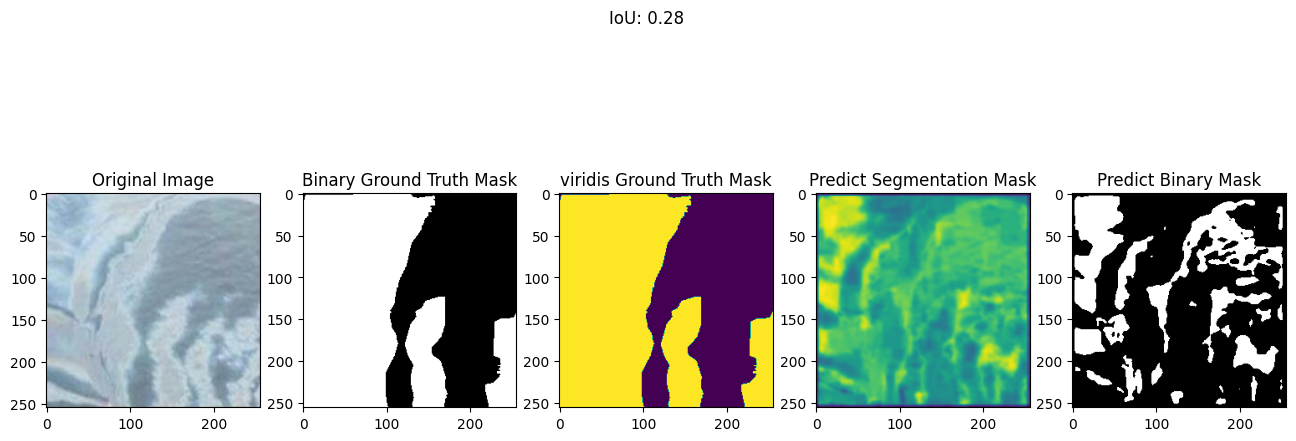

1/1 [==============================] - 1s 1s/step


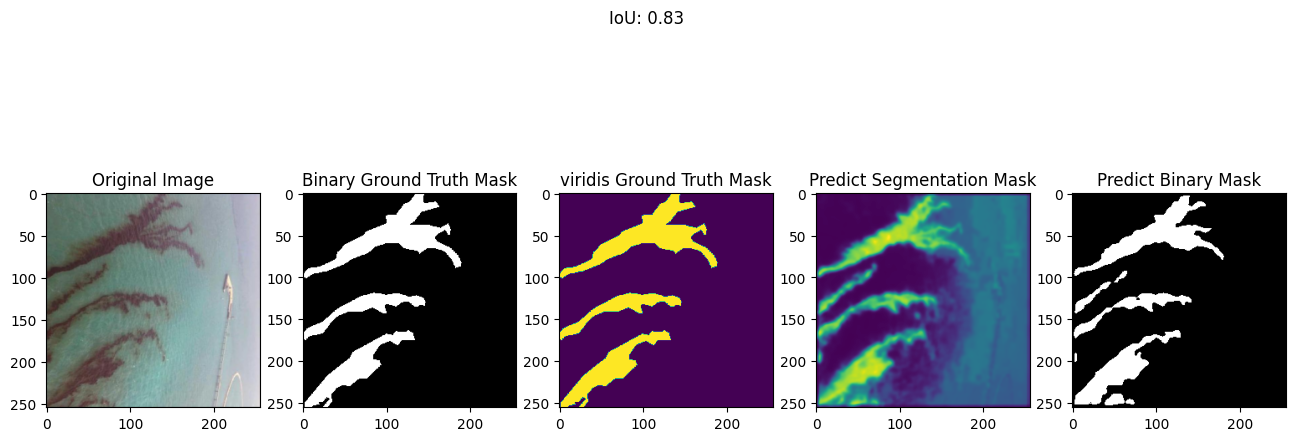

1/1 [==============================] - 0s 407ms/step


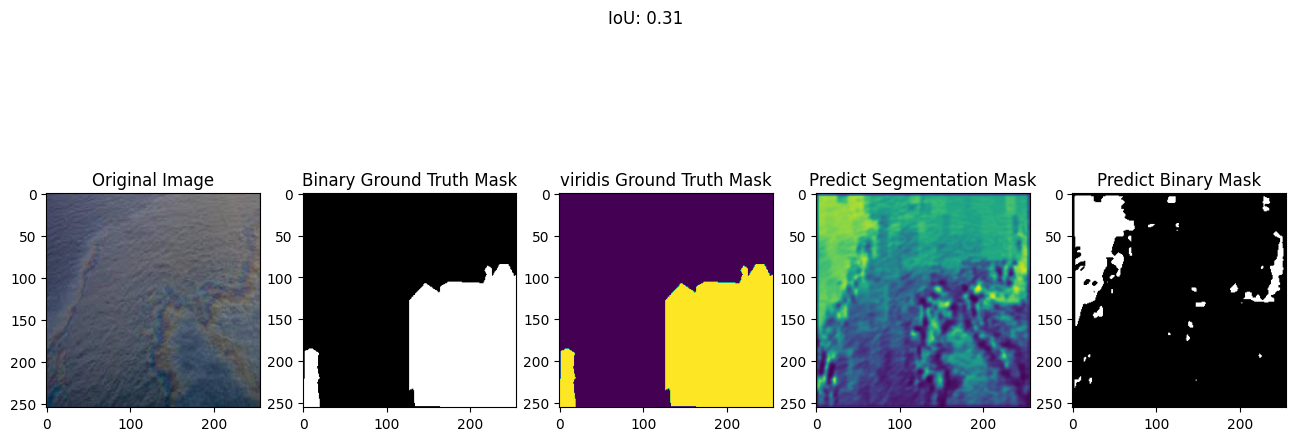

1/1 [==============================] - 0s 424ms/step


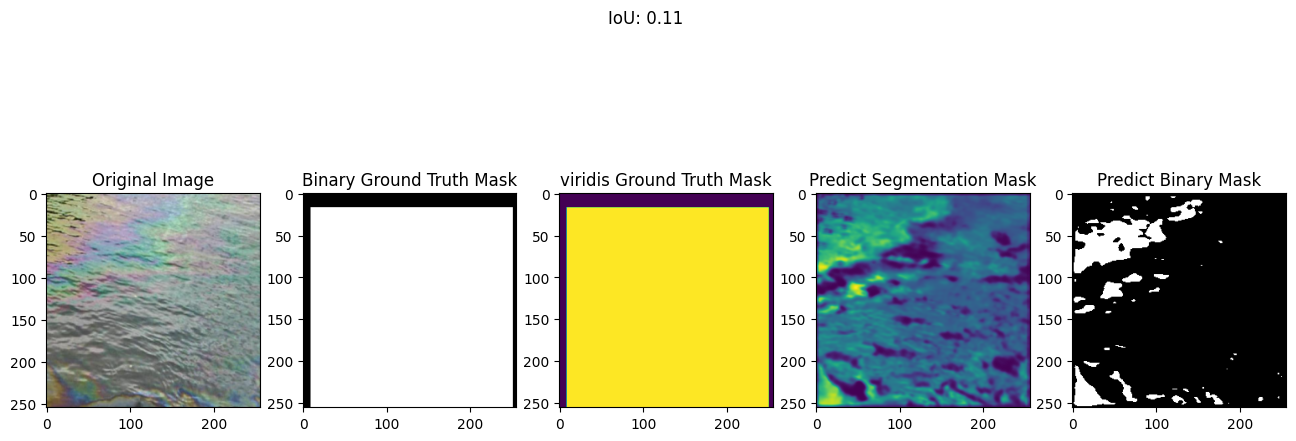

1/1 [==============================] - 0s 450ms/step


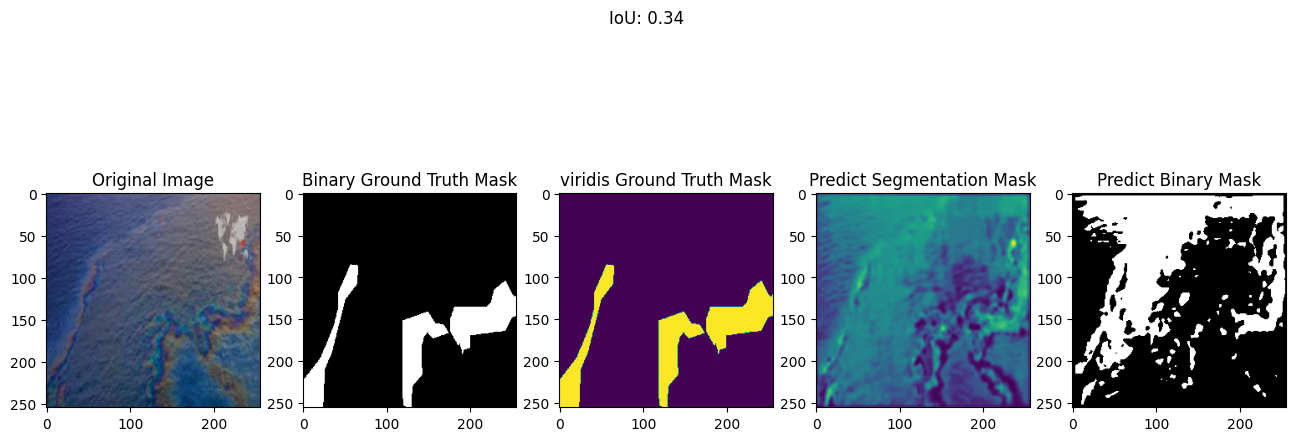

1/1 [==============================] - 0s 450ms/step


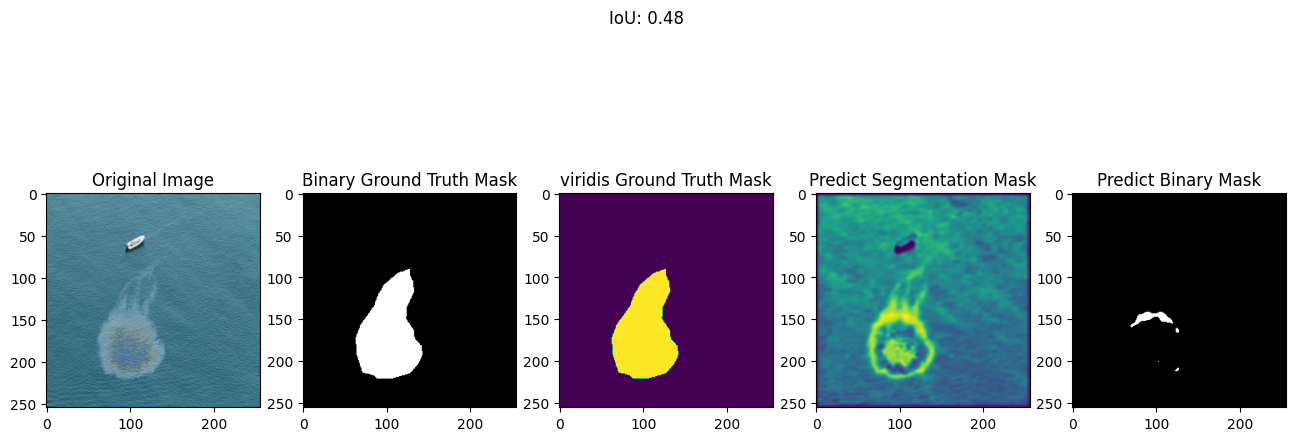

1/1 [==============================] - 0s 406ms/step


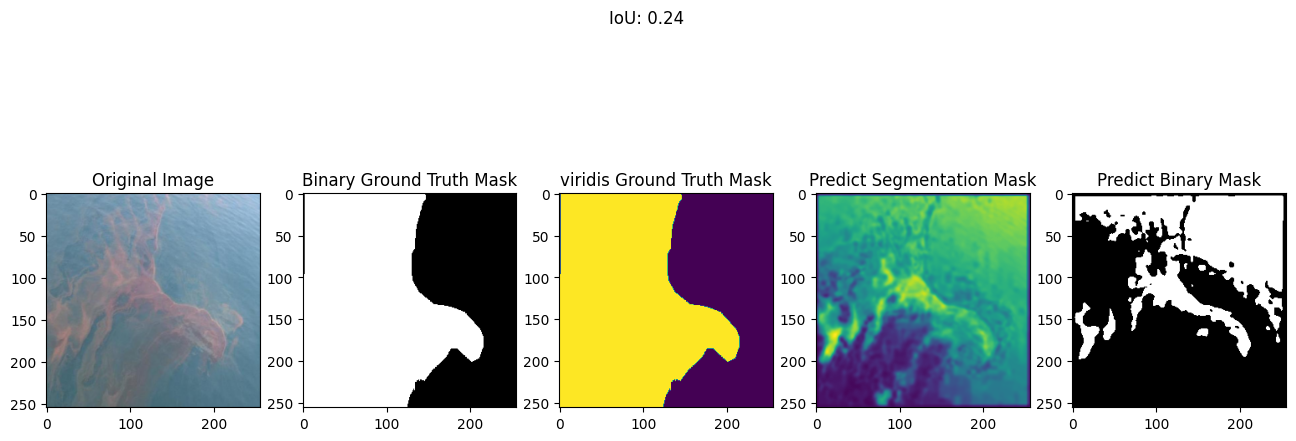

1/1 [==============================] - 0s 421ms/step


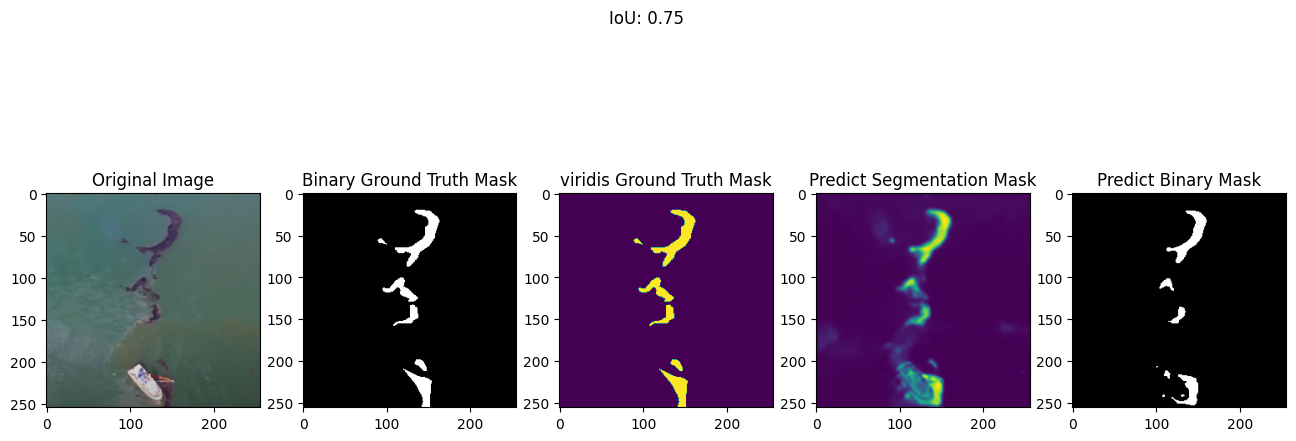

1/1 [==============================] - 1s 727ms/step


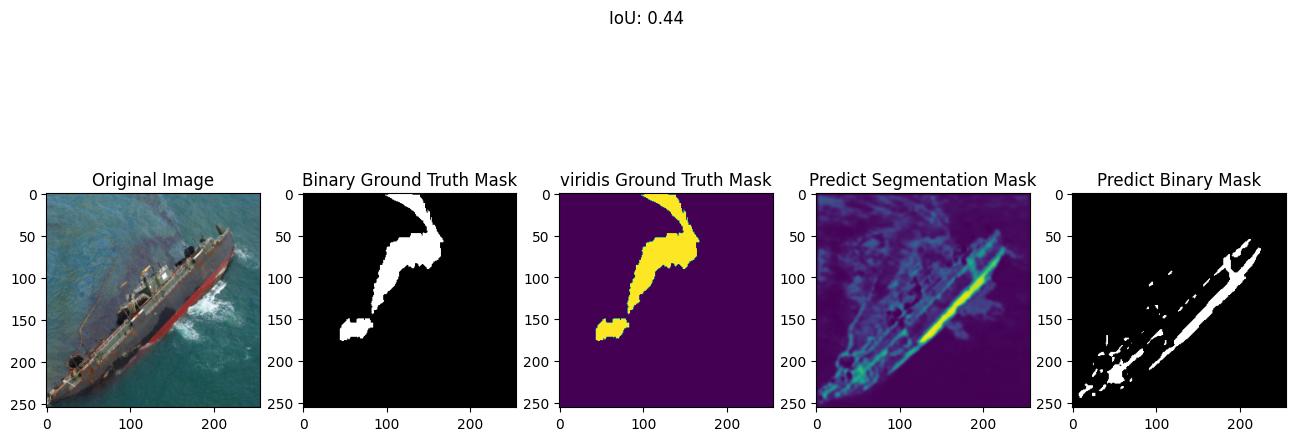

1/1 [==============================] - 1s 684ms/step


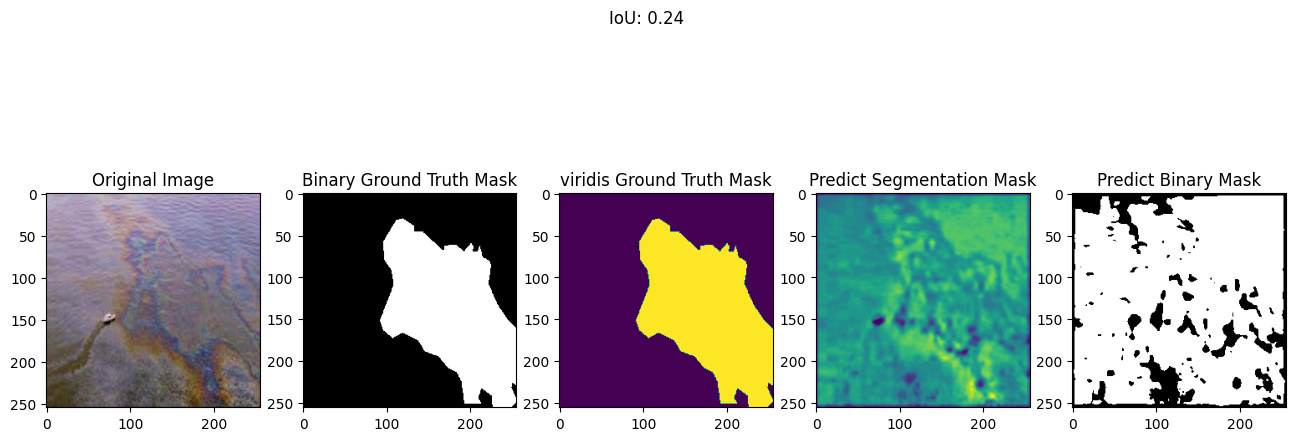

1/1 [==============================] - 0s 419ms/step


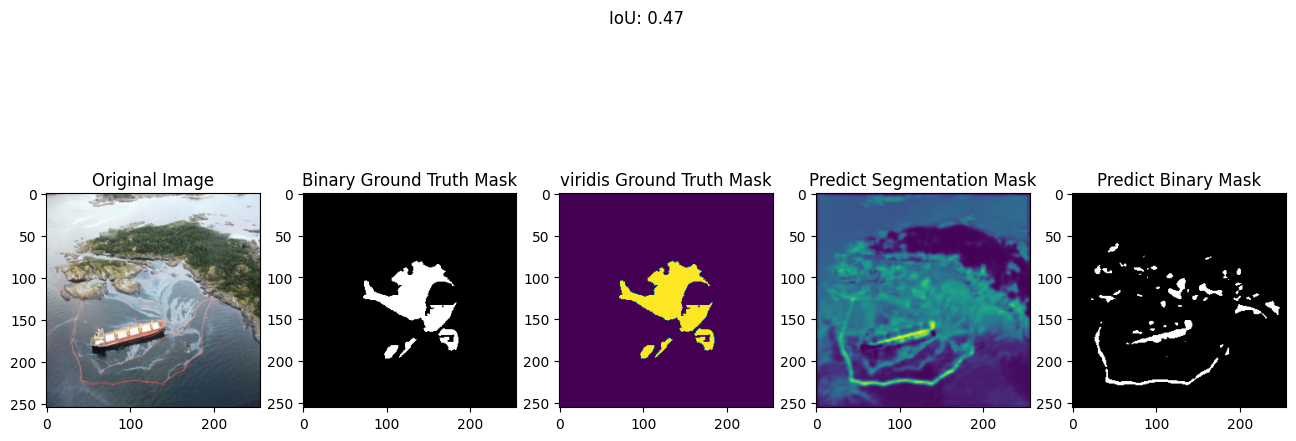

1/1 [==============================] - 0s 400ms/step


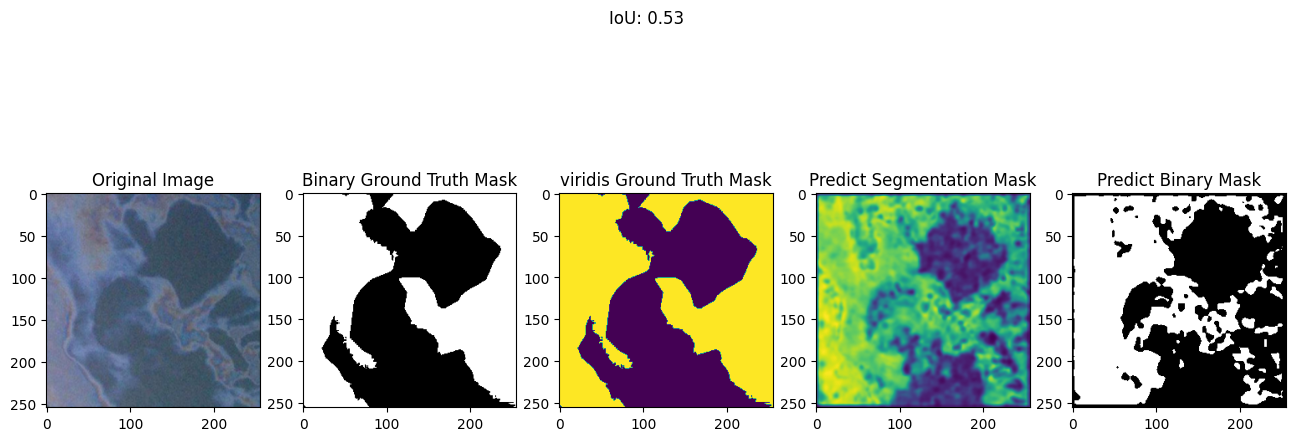

1/1 [==============================] - 0s 467ms/step


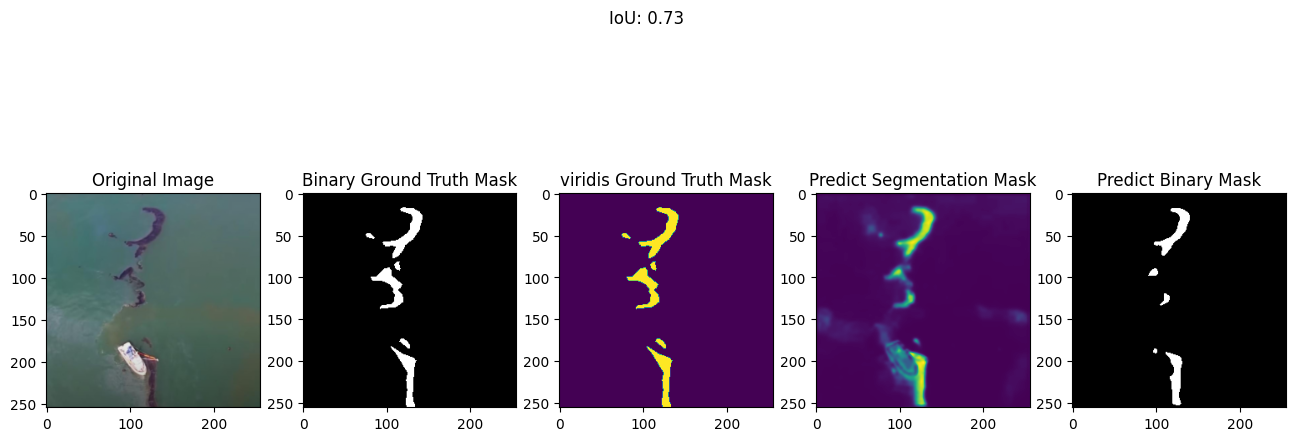

1/1 [==============================] - 0s 406ms/step


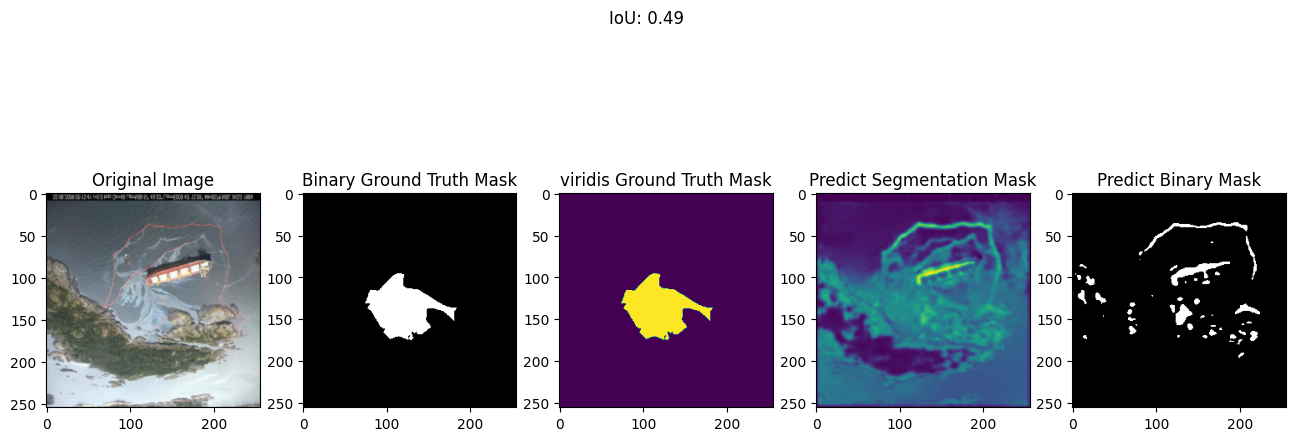

1/1 [==============================] - 0s 416ms/step


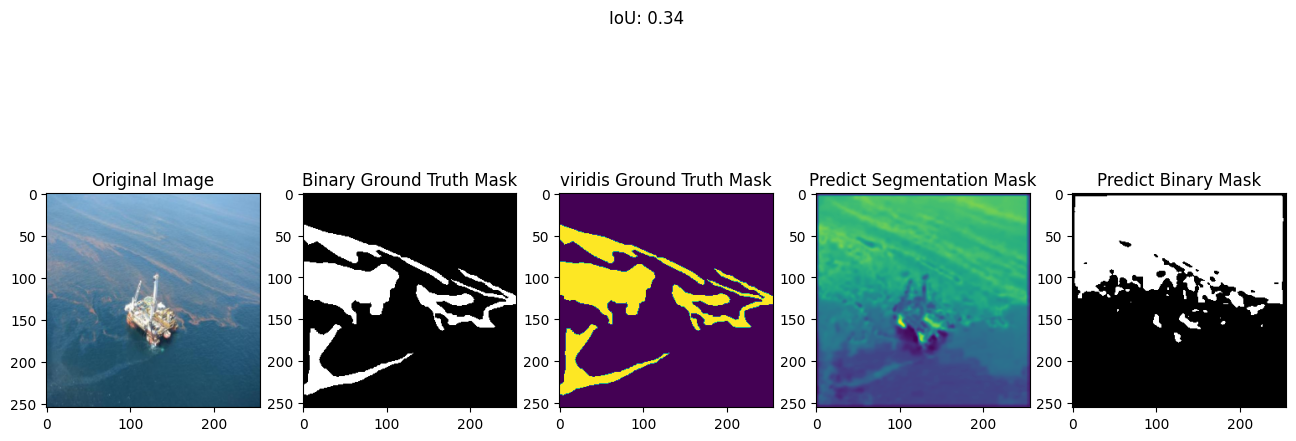

Average mIoU: 0.4384


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import json
import os
from pycocotools.coco import COCO
from skimage.transform import resize
from sklearn.metrics import confusion_matrix

# Load the U-Net model
model = keras.models.load_model('/content/unet_model.h5')

# Load COCO annotations
test_annotation_path = '/content/dataset/test_annotation.json'
with open(test_annotation_path, 'r') as f:
    test_annotations = json.load(f)

# Set up COCO API for loading images
coco_test = COCO(test_annotation_path)

# Function to preprocess an image for segmentation
def preprocess_for_segmentation(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Function to perform segmentation using the U-Net model
def segment_image(model, image_path):
    preprocessed_image = preprocess_for_segmentation(image_path)
    segmentation_mask = model.predict(preprocessed_image)[0, :, :, 0]
    return segmentation_mask

# Function to generate ground truth mask
def generate_groundtruth(image_info, annotation_ids, target_size=(256, 256)):
    gt_mask = np.zeros((image_info['height'], image_info['width']))

    annotations = coco_test.loadAnns(annotation_ids)
    for annotation in annotations:
        segmentation = annotation['segmentation']
        for segment in segmentation:
            poly = np.array(segment).reshape((len(segment)//2, 2))
            poly = np.round(poly).astype(int)
            cv2.fillPoly(gt_mask, [poly], 1)

    # Resize ground truth mask to target size (255x255)
    resized_gt_mask = cv2.resize(gt_mask, target_size, interpolation=cv2.INTER_NEAREST)
    return resized_gt_mask

# Calculate mIoU
miou_list = []

for j in os.listdir('/content/dataset/test'):
    example_image_path = '/content/dataset/test/' + j
    for i in range(len(os.listdir('/content/dataset/test'))):
        if (test_annotations['images'][i]['file_name'] == example_image_path.split("/")[4]):

            # Load an example image from the test set
            # Get the corresponding annotation IDs for the image
            image_info = coco_test.loadImgs(coco_test.getImgIds(imgIds=i))[0]
            annotation_ids = coco_test.getAnnIds(imgIds=image_info['id'])

            # Resize original image to target size (255x255)
            original_image = plt.imread(example_image_path)
            resized_original_image = resize(original_image, (255, 255), mode='constant', anti_aliasing=True)

            # Perform segmentation
            segmentation_result = segment_image(model, example_image_path)

            # Threshold the segmentation mask (you can adjust the threshold)
            threshold = 0.25
            binary_mask = (segmentation_result > threshold).astype(np.uint8)

            # Resize ground truth mask to target size (255x255)
            resized_gt_mask = generate_groundtruth(image_info, annotation_ids)

            # Compute confusion matrix
            # Compute confusion matrix
            cm = confusion_matrix(np.ravel(resized_gt_mask), np.ravel(binary_mask))

            # Calculate IoU for each class
            intersection = np.diag(cm)
            union = np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm)
            iou = intersection / union.astype(np.float32)

            # Calculate mIoU
            miou = np.mean(iou)
            miou_list.append(miou)

            # Display the resized original image, segmentation mask, binary mask, and resized ground truth mask
            plt.figure(figsize=(16, 6))

            plt.subplot(1, 5, 1)
            plt.imshow(resized_original_image)
            plt.title('Original Image')

            plt.subplot(1, 5, 2)
            plt.imshow(resized_gt_mask, cmap='gray')
            plt.title('Binary Ground Truth Mask')

            plt.subplot(1, 5, 3)
            plt.imshow(resized_gt_mask, cmap='viridis')
            plt.title('viridis Ground Truth Mask')

            plt.subplot(1, 5, 4)
            plt.imshow(segmentation_result, cmap='viridis')
            plt.title('Predict Segmentation Mask')

            plt.subplot(1, 5, 5)
            plt.imshow(binary_mask, cmap='gray')
            plt.title('Predict Binary Mask')

            plt.suptitle(f'IoU: {miou:.2f}')

            plt.show()
            break

# Calculate and print the average mIoU
average_miou = np.mean(miou_list)
print(f'Average IoU: {average_miou:.4f}')
